In [ ]:
!pip install denoisers
!pip install pedalboard
!pip install pytorch_lightning
!pip install pesq
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 6.0 MB/s eta 0:00:00


In [ ]:
import torch
import torchaudio
from denoisers import WaveUNetModel
from tqdm import tqdm
import numpy as np

model = WaveUNetModel.from_pretrained("wrice/waveunet-vctk-24khz")

clean_audio, sr = torchaudio.load("/content/audiocheck.net_whitenoise.wav")

if sr != model.config.sample_rate:
    clean_audio = torchaudio.functional.resample(clean_audio, sr, model.config.sample_rate)

if clean_audio.size(0) > 1:
    clean_audio = clean_audio.mean(0, keepdim=True)

chunk_size = model.config.max_length

padding = abs(clean_audio.size(-1) % chunk_size - chunk_size)
padded_clean = torch.nn.functional.pad(clean_audio, (0, padding))

noise_level = 0.05

noise = torch.randn_like(clean_audio) * noise_level

noisy_audio = clean_audio + noise
# noisy_audio=clean_audio

torchaudio.save("/content/noisy_audio.wav", noisy_audio, model.config.sample_rate)
padded_noisy = torch.nn.functional.pad(noisy_audio, (0, padding))

clean = []
for i in tqdm(range(0, padded_noisy.shape[-1], chunk_size)):
    audio_chunk = padded_noisy[:, i:i + chunk_size]
    with torch.no_grad():
        clean_chunk = model(audio_chunk[None]).audio
    clean.append(clean_chunk.squeeze(0))

denoised = torch.cat(clean, 1)[:, :noisy_audio.shape[-1]]

output_path = "/content/denoised_audio.wav"
torchaudio.save(output_path, denoised, model.config.sample_rate)
print("Denoised audio saved to:", output_path)

100%|██████████| 2/2 [00:04<00:00,  2.11s/it]

Denoised audio saved to: /content/denoised_audio.wav


In [ ]:
import os
import torch
import torchaudio
from denoisers import WaveUNetModel
import numpy as np

# Load the WaveUNet model
model = WaveUNetModel.from_pretrained("wrice/waveunet-vctk-24khz")

# Define the path to the GTZAN dataset
gtzan_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues"

# Function to add noise to audio
def add_noise(audio, noise_level=0.05):
    noise = torch.randn_like(audio) * noise_level
    return audio + noise

# Function to calculate loss between clean and denoised audio
def calculate_loss(clean_audio, denoised_audio):
    loss_fn = torch.nn.MSELoss()
    return loss_fn(clean_audio, denoised_audio)

# Iterate through all .wav files in the GTZAN dataset
total_loss = 0.0
total_files = 0

for root, dirs, files in os.walk(gtzan_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)

            # Load the clean audio
            clean_audio, sr = torchaudio.load(file_path)

            # Resample if needed
            if sr != model.config.sample_rate:
                clean_audio = torchaudio.functional.resample(clean_audio, sr, model.config.sample_rate)

            if clean_audio.size(0) > 1:
                clean_audio = clean_audio.mean(0, keepdim=True)

            # Add noise to clean audio
            noisy_audio = add_noise(clean_audio)

            # Denoise the noisy audio
            with torch.no_grad():
                denoised_audio = model(noisy_audio[None]).audio.squeeze(0)

            # Calculate loss
            loss = calculate_loss(clean_audio, denoised_audio)
            total_loss += loss.item()
            total_files += 1

# Calculate average loss
average_loss = total_loss / total_files
print("Average Loss:", average_loss)


In [ ]:
import numpy as np

original_audio_np = noisy_audio.squeeze().numpy()
denoised_audio_np = denoised.squeeze().numpy()

signal_power = np.sum(original_audio_np ** 2)

noise = original_audio_np - denoised_audio_np
noise_power = np.sum(noise ** 2)

SNR = 10 * np.log10(signal_power / noise_power)
print("Signal-to-Noise Ratio (SNR) in dB:", SNR)


Signal-to-Noise Ratio (SNR) in dB: 0.3698693960905075


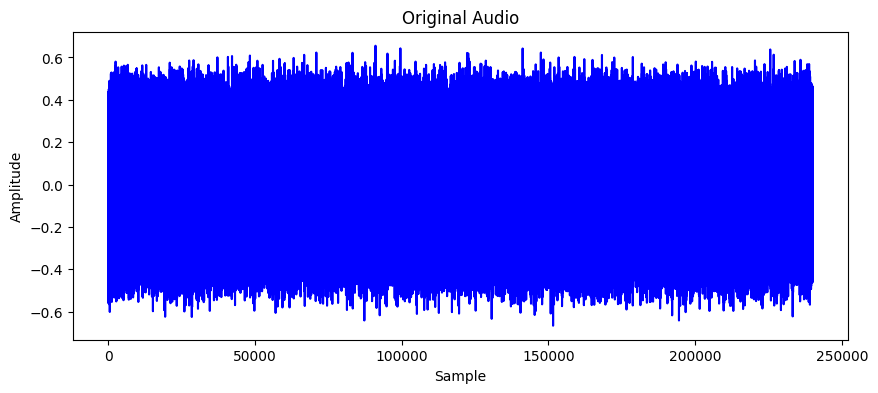

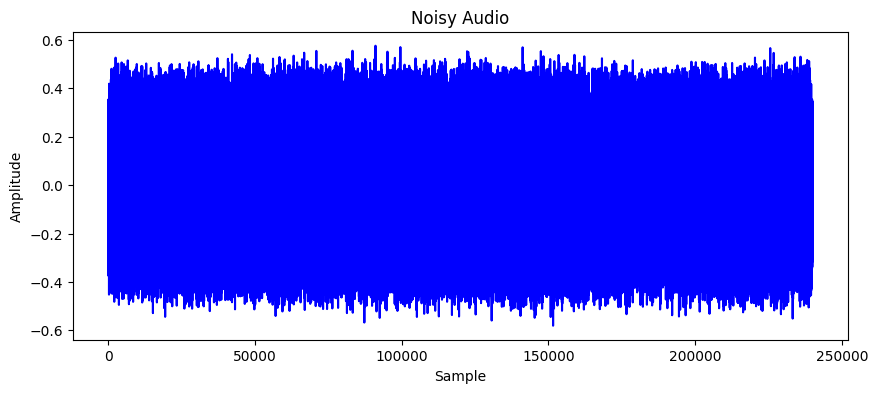

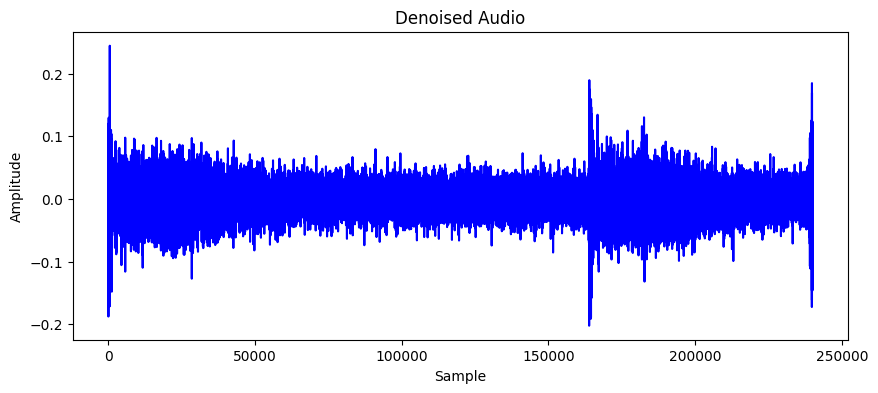

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(original_audio_np, color='blue')
plt.title("Original Audio")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(noise, color='blue')
plt.title("Noisy Audio")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.savefig('Noise.pdf', dpi=600, bbox_inches='tight')
plt.show()
plt.figure(figsize=(10, 4))
plt.plot(denoised_audio_np, color='blue')
plt.title("Denoised Audio")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.savefig('Denoised.pdf', dpi=600, bbox_inches='tight')
plt.show()

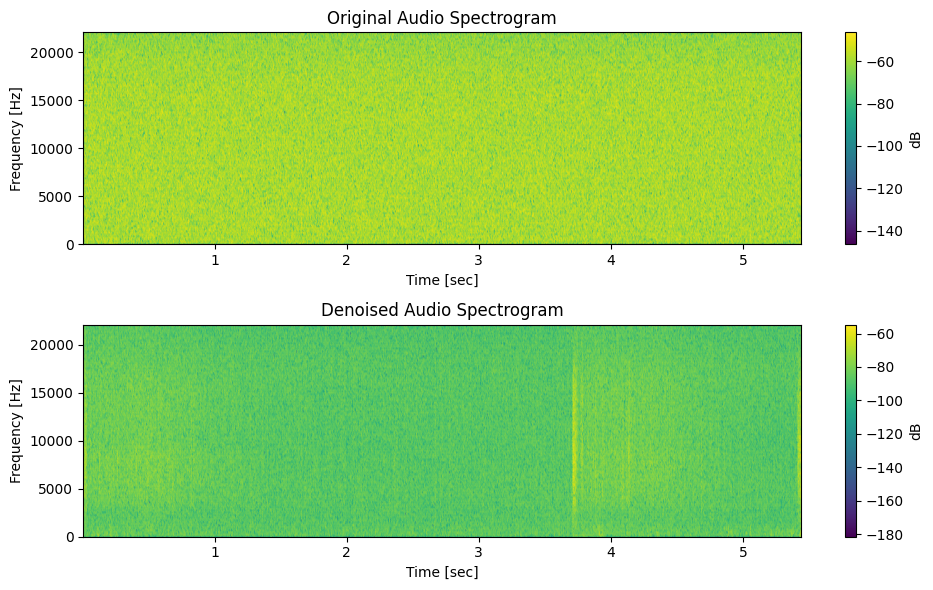

In [ ]:
from scipy.signal import spectrogram

frequencies, times, spec_original = spectrogram(original_audio_np, fs=sr)
_, _, spec_denoised = spectrogram(denoised_audio_np, fs=sr)

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, 10 * np.log10(spec_original), shading='gouraud')
plt.title("Original Audio Spectrogram")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='dB')
plt.subplot(2, 1, 2)
plt.pcolormesh(times, frequencies, 10 * np.log10(spec_denoised), shading='gouraud')
plt.title("Denoised Audio Spectrogram")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='dB')
plt.tight_layout()
plt.savefig('Spectrum.pdf', dpi=600, bbox_inches='tight')
plt.show()

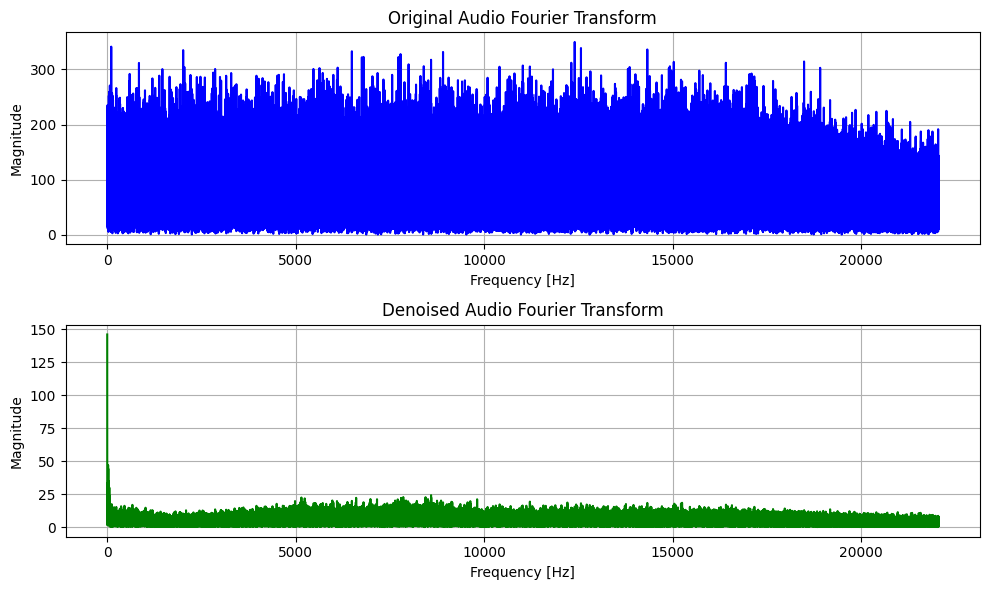

In [ ]:
original_fft = np.fft.fft(original_audio_np)
denoised_fft = np.fft.fft(denoised_audio_np)

freq_axis = np.fft.fftfreq(len(original_audio_np), 1 / sr)

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(freq_axis[:len(freq_axis)//2], np.abs(original_fft)[:len(freq_axis)//2], color='blue')
plt.title("Original Audio Fourier Transform")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(freq_axis[:len(freq_axis)//2], np.abs(denoised_fft)[:len(freq_axis)//2], color='green')
plt.title("Denoised Audio Fourier Transform")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid(True)
plt.tight_layout()

plt.savefig('fft.pdf', dpi=600, bbox_inches='tight')
plt.show()